In [1]:
#Import knižníc
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, BertTokenizerFast, BertConfig
import torch
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

/Users/annahavryliak/IdeaProjects/ZS2/pythonProject/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/annahavryliak/IdeaProjects/ZS2/pythonProject/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
#Nacitanie datasetu
df = pd.read_csv('data/test.csv')

In [3]:
#Spracovanie datasetu
def clean_text(text):
    #Previesť text na malé písmená
    text = text.lower()
    
    #Odstránenie adries URL
    text = re.sub(r'http\S+', '', text)
    
    #Odstránenie hashtagov (iba symbol „#“, text ponechajte)
    text = re.sub(r'#', '', text)
    
    #Odstránenie špeciálnych znakov a čísel
    text = ''.join(c for c in text if c.isalnum() or c.isspace())
    
    #Odstránenie zbytočných medzier
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [4]:
#Zápis očistených údajov do nového stĺpca
df['clear'] = df['tweet'].apply(clean_text)

In [5]:
#Stiahnutie tokenizéra
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [6]:
#Tokenizácia textu s obmedzením dĺžky
def tokenize_text(text, tokenizer, max_length=128):
    tokens = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return tokens['input_ids'], tokens['attention_mask']

In [7]:
#Vytvorenie nových stĺpcov pre tokeny
df['input_ids'] = df['clear'].apply(lambda x: tokenize_text(x, tokenizer)[0])
df['attention_mask'] = df['clear'].apply(lambda x: tokenize_text(x, tokenizer)[1])

In [8]:
#Stiahnutie modelu
model_dir = 'bert_seq'

#Stiahnutie tokenizéra
tokenizer = BertTokenizerFast.from_pretrained(model_dir)

#Stiahnutie konfigurácie modelu
config_path = f"{model_dir}/config.json"
model_config = {
    "vocab_size": tokenizer.vocab_size,
    "hidden_size": 768,
    "num_labels": 2,
}

In [9]:
#Vytvorenie modelovej konfigurácie
model_config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_labels=2
)

In [10]:
#Nahratie modelu s konfiguráciou
model = BertForSequenceClassification.from_pretrained(
    model_dir,
    config=model_config
)

In [11]:
#Konverzia modelu do GPU, ak je k dispozícii
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

In [12]:
#Funkcia na predpovedanie triedy (fake/real) pomocou modelu
def predict_post(input_ids, attention_mask, model, device):
    #Kontrola, či input_ids a attention_mask sú tenzory
    if not isinstance(input_ids, torch.Tensor):
        input_ids = torch.tensor(input_ids)
    if not isinstance(attention_mask, torch.Tensor):
        attention_mask = torch.tensor(attention_mask)
    
    #Pridanie rozmeru banch, ak neexistuje
    if len(input_ids.shape) == 1:
        input_ids = input_ids.unsqueeze(0)
    if len(attention_mask.shape) == 1:
        attention_mask = attention_mask.unsqueeze(0)
    
    #Prenos dát do príslušného zariadenia (CPU/GPU)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    #Vyhovenie predikcii
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    #Získanie predikcie triedy
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    #Vrátenie výsledku (0 - fake, 1 - real)
    return "real" if predicted_class == 0 else "fake"

In [13]:
#Použitie modelu na každý post v datasete
def analyze_posts(df, model, device):
    #Vytvorenie nového stĺpca pre výsledky predikcie
    df['prediction'] = df.apply(
        lambda row: predict_post(row['input_ids'], row['attention_mask'], model, device), axis=1
    )
    return df

In [14]:
#Vykonávanie následnej analýzy
df = analyze_posts(df, model, device)

In [19]:
#Ukladanie datasetu
df.to_csv('data/test_seq.csv', index=False)

In [20]:
#Nacitanie noveho datasetu
df_test = pd.read_csv('data/test_seq.csv')

In [21]:
#Porovnanie hodnôt v stĺpcoch
df_test['result'] = df_test['label'] == df_test['prediction']

#Počítanie počtu zhody a nezhody
resulttrue = df_test['result'].sum()
resultfalse = len(df_test)-resulttrue

print(f"Počet zápasov: {resulttrue}")
print(f"Počet nezhod: {resultfalse}")

Počet zápasov: 2041
Počet nezhod: 99


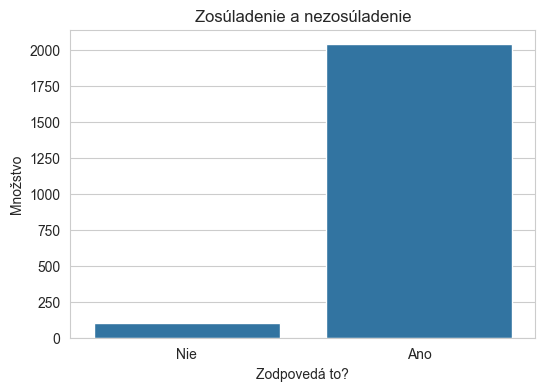

In [22]:
#Vizualizácia zhody a nezhody
plt.figure(figsize=(6, 4))
sns.countplot(x='result', data=df_test)
plt.title('Zosúladenie a nezosúladenie')
plt.xlabel('Zodpovedá to?')
plt.ylabel('Množstvo')
plt.xticks([0, 1], ['Nie', 'Ano'])
plt.show()

In [24]:
#Výpočet kľúčových metrík
accuracy = accuracy_score(df_test['label'], df_test['prediction'])
precision = precision_score(df_test['label'], df_test['prediction'], pos_label='real')
recall = recall_score(df_test['label'], df_test['prediction'], pos_label='real')
f1 = f1_score(df_test['label'], df_test['prediction'], pos_label='real')

#Vytvorenie DataFrame pre metriky
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [f"{accuracy:.2f}", f"{precision:.2f}", f"{recall:.2f}", f"{f1:.2f}"]
})
metrics

,Metric,Value
0,Accuracy,0.95
1,Precision,0.95
2,Recall,0.97
3,F1-Score,0.96


In [26]:
conf_matrix = confusion_matrix(df_test['label'], df_test['prediction'], labels=['fake', 'real'])

#Výstup confusion matrix
conf_matrix = pd.DataFrame(
    conf_matrix,
    index=['True Fake', 'True Real'],
    columns=['Predicted Fake', 'Predicted Real']
)
conf_matrix

,Predicted Fake,Predicted Real
True Fake,958,62
True Real,37,1083


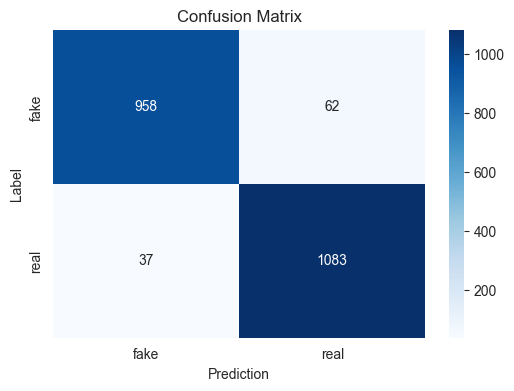

In [27]:
#Vizualizacia confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()